### Init

In [1]:
from tsplearn import *
import numpy as np 
import pandas as pd

prob_T=0.50

# Load the graph
G = EnhancedGraph(n=40, p_edges=0.162, p_triangles=prob_T, seed=0)
B1 = G.get_b1()
B2 = G.get_b2()

# Sub-sampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]
nu = B2.shape[1]
nd = B1.shape[1]
T = int(np.ceil(nu*(1-prob_T)))

# Laplacians
Lu, Ld, L = G.get_laplacians(sub_size=100)
Lu_full = G.get_laplacians(sub_size=100, full=True)
B2_true = B2@G.mask
M =  L.shape[0]


# Problem and Dictionary Dimensionalities
dictionary_type="separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
P = 3 # Number of Kernels (Sub-dictionaries)
J = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(M*sparsity) # Sparsity
sparsity_mode = "max"
n_search = 3000
n_sim = 10

# Data-Independent Problem Hyperparameters
K0_coll = np.arange(5, 26, 4) 
max_iter = 100 
patience = 5 
tol = 1e-7 # tolerance for Patience
lambda_ = 1e-7 # l2 multiplier
verbose = True

In [3]:
gen_params={'dictionary_type':dictionary_type,
        'm_train':m_train,
        'm_test':m_test,
        'P':P,
        'M':M,
        'J':J,
        'sparsity':sparsity,
        'K0_max':K0_max,
        'sparsity_mode':sparsity_mode,
        'n_search':n_search,
        'n_sim':n_sim,
        'prob_T':prob_T}

In [4]:
load_data = generate_data(Lu, Ld, **gen_params)

D_true = load_data['D_true']
Y_train = load_data['Y_train']
Y_test = load_data['Y_test']
X_train = load_data['X_train']
X_test = load_data['X_test']
epsilon_true =  load_data['epsilon_true']
c_true = load_data['c_true']

In [5]:
s = 8
c = c_true[s]  
epsilon = epsilon_true[s] 
k0 = K0_coll[4]

topo_params = {"K0":K0_coll[4],
               "J":J,
               "P":P,
               "true_prob_T":prob_T,
               "sub_size":100,
               "dictionary_type":dictionary_type,
               "c":c_true[s],
               "epsilon":epsilon_true[s],
               "seed":0,
               "n":40,
               "p_edges":0.162
               }

### The class

In [119]:
import scipy.linalg as sla
import numpy as np
import numpy.linalg as la
import cvxpy as cp
from tsplearn.tsp_generation import *
from typing import Tuple, List, Union, Dict
import pickle
from functools import wraps


def _indicator_matrix(row):
    tmp = row.sigma.copy()
    tmp[row.idx] = 0
    return np.diag(tmp)

def _indicator_matrix_rev(row):
    tmp = row.sigma.copy()
    tmp[row.idx] = 1
    return np.diag(tmp)

def _compute_Luj(row, b2, J):
    Lu = b2 @ row.sigma @ b2.T
    Luj = np.array([la.matrix_power(Lu, i) for i in range(1, J + 1)])
    return Luj

def _split_coeffs(h ,s ,k):
    h_tmp = h.value.flatten()
    hH = h_tmp[np.arange(0, (s*(2*k+1)), (2*k+1))].reshape((s,1))
    hS = h_tmp[np.hstack([[i,i+1] for i in range(1, (s*(2*k+1)), (2*k+1))])].reshape((s,k))
    hI = h_tmp[np.hstack([[i,i+1] for i in range((k+1), (s*(2*k+1)), (2*k+1))])].reshape((s,k))
    return [hH, hS, hI]
    
def sparse_transform(D, K0, Y_te, Y_tr=None):

    dd = la.norm(D, axis=0)
    W = np.diag(1. / dd)
    Domp = D @ W
    X_te = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_te)
    # Normalization
    X_te = W @ X_te

    if np.all(Y_tr == None):

        return X_te
    
    # Same for the training set
    X_tr = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_tr)
    X_tr = W @ X_tr
    
    return X_te, X_tr


def compute_vandermonde(L, k):
    
    def polynomial_exp(x, k):
        x = x** np.arange(0, k + 1)
        return x

    eigenvalues, _ = sla.eig(L)
    idx = eigenvalues.argsort()
    tmp_df = pd.DataFrame({'Eigs': eigenvalues[idx]})
    tmp_df['Poly'] = tmp_df['Eigs'].apply(lambda x:  polynomial_exp(x,k))
    B = np.vstack(tmp_df['Poly'].to_numpy())

    return B


def nmse(D, X, Y, m):
    return (1/m)* np.sum(la.norm(Y - (D @ X), axis=0)**2 /la.norm(Y, axis=0)**2)


class TspSolver:

    def __init__(self, X_train, X_test, Y_train, Y_test, *args, **kwargs):

        params = {
                'P': None,      # Number of Kernels (Sub-dictionaries)
                'J': None,      # Polynomial order
                'K0': None,     # Sparsity level
                'dictionary_type': None,
                'c': None,      # spectral control parameter 
                'epsilon': None,# spectral control parameter
                'n': 10,        # number of nodes
                'sub_size': None,   # Number of sub-sampled nodes
                'prob_T': 1.,   # Ratio of colored triangles
                'true_prob_T': 1.,   # True ratio of colored triangles
                'p_edges': 1.,  # Probability of edge existence
                'seed': None
                }
        
        if args:
            if len(args) != 1 or not isinstance(args[0], dict):
                raise ValueError("When using positional arguments, must provide a single dictionary")
            params.update(args[0])

        params.update(kwargs)

        # Data
        self.X_train: np.ndarray = X_train
        self.X_test: np.ndarray = X_test
        self.Y_train: np.ndarray = Y_train
        self.Y_test: np.ndarray = Y_test
        self.m_train: int = Y_train.shape[1]
        self.m_test: int = Y_test.shape[1]

        # Topology and geometry behind data
        self.G = EnhancedGraph(n=params['n'],
                               p_edges=params['p_edges'], 
                               p_triangles=params['prob_T'], 
                               seed=params['seed'])
        self.B1: np.ndarray = self.G.get_b1()
        self.B2: np.ndarray = self.G.get_b2()

        # Sub-sampling if needed to decrease complexity
        if params['sub_size'] != None:
            self.B1 = self.B1[:, :params['sub_size']]
            self.B2 = self.B2[:params['sub_size'], :]
            self.B2 = self.B2[:,np.sum(np.abs(self.B2), 0) == 3]
        self.nu: int = self.B2.shape[1]
        self.nd: int = self.B1.shape[1]
        self.true_prob_T = params['true_prob_T']
        self.T: int = int(np.ceil(self.nu*(1-params['prob_T'])))

        # Laplacians
        Lu, Ld, L = self.G.get_laplacians(sub_size=params['sub_size'])
        self.Lu: np.ndarray = Lu
        self.Ld: np.ndarray = Ld
        self.L: np.ndarray = L
        self.Lu_full: np.ndarray = G.get_laplacians(sub_size=params['sub_size'], 
                                                    full=True)
        self.M =  L.shape[0]
        self.history: List[np.ndarray] = []

        # Dictionary, parameters and hyperparameters for compression
        self.P = params['P']
        self.J = params['J']
        self.c = params['c']
        self.epsilon = params['epsilon']
        self.K0 = params['K0']
        self.dictionary_type = params['dictionary_type']
        self.D_opt: np.ndarray = np.zeros((self.M, self.M*self.P))

        if self.dictionary_type=="separated":
            hs = np.zeros((self.P,self.J))
            hi = np.zeros((self.P,self.J))
            hh = np.zeros((self.P,1))
            self.h_opt: List[np.ndarray] = [hh,hs,hi]
        else:
            self.h_opt: np.ndarray = np.zeros((self.P*(self.J+1),1))
            
        self.X_opt_train: np.ndarray = np.zeros(self.X_train.shape)
        self.X_opt_test: np.ndarray = np.zeros(self.X_test.shape)

        if self.dictionary_type == "joint":
            self.Lj, self.lambda_max_j, self.lambda_min_j = compute_Lj_and_lambdaj(self.L, self.J)
            self.B = compute_vandermonde(self.L, self.J).real
        elif self.dictionary_type == "edge_laplacian":
            self.Lj, self.lambda_max_j, self.lambda_min_j = compute_Lj_and_lambdaj(self.Ld, self.J)
            self.B = compute_vandermonde(self.Ld, self.J).real
        elif  self.dictionary_type == 'separated':
            self.Luj, self.lambda_max_u_j, self.lambda_min_u_j = compute_Lj_and_lambdaj(self.Lu, self.J, separated=True)
            self.Ldj, self.lambda_max_d_j, self.lambda_min_d_j = compute_Lj_and_lambdaj(self.Ld, self.J, separated=True)
            self.Bu = compute_vandermonde(self.Lu, self.J).real
            self.Bd = compute_vandermonde(self.Ld, self.J)[:, 1:].real
            self.B = np.hstack([self.Bu, self.Bd])

        self.P_aux: np.ndarray = None

        # Init the learning errors
        self.min_error_train = 1e20
        self.min_error_test = 1e20

    # def fit(self) -> Tuple[float, List[np.ndarray], np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    #     min_error_test, _, _, h_opt, X_opt_test, D_opt = self.learn_upper_laplacian()
    #     return min_error_test, self.history, params['Lu'], h_opt, X_opt_test, D_opt

    def update_Lu(self, Lu_new):
        self.Lu = Lu_new
        self.Luj, self.lambda_max_u_j, self.lambda_min_u_j = compute_Lj_and_lambdaj(self.Lu, 
                                                                                    self.J, 
                                                                                    separated=True)
        self.Bu = compute_vandermonde(self.Lu, self.J).real
        self.B = np.hstack([self.Bu, self.Bd])

    @staticmethod
    def _multiplier_search(*arrays, P, c, epsilon):
        is_okay = 0
        mult = 100
        tries = 0
        while is_okay==0:
            is_okay = 1
            h, c_try, _, tmp_sum_min, tmp_sum_max = generate_coeffs(arrays, P=P, mult=mult)
            if c_try <= c:
                is_okay *= 1
            if tmp_sum_min > c-epsilon:
                is_okay *= 1
                incr_mult = 0
            else:
                is_okay = is_okay*0
                incr_mult = 1
            if tmp_sum_max < c+epsilon:
                is_okay *= 1
                decr_mult = 0
            else:
                is_okay *= 0
                decr_mult = 1
            if is_okay == 0:
                tries += 1
            if tries >3:
                discard = 1
                break
            if incr_mult == 1:
                mult *= 2
            if decr_mult == 1:
                mult /= 2
        return h, discard

    def init_dict(self,
                  h_prior: np.ndarray = None, 
                  mode: str = "only_X") -> Tuple[np.ndarray, np.ndarray]:
        """
        Initialize the dictionary and the signal sparse representation for the alternating
        optimization algorithm.

        Args:
            Lu (np.ndarray): Upper Laplacian matrix
            Ld (np.ndarray): Lower Laplacian matrix
            P (int): Number of kernels (sub-dictionaries).
            J (int): Max order of the polynomial for the single sub-dictionary.
            Y_train (np.ndarray): Training data.
            K0 (int): Sparsity of the signal representation.
            dictionary_type (str): Type of dictionary.
            c (float): Boundary constant from the synthetic data generation process.
            epsilon (float): Boundary constant from the synthetic data generation process.
            only (str): Type of initialization. Can be one of: "only_X", "all", "only_D".

        Returns:
            Tuple[np.ndarray, np.ndarray, bool]: Initialized dictionary, initialized sparse representation, and discard flag value.
        """
        
        # If no prior info on the dictionary
        if np.all(h_prior == None):

            if (mode in ["all","only_D"]):

                discard = 1
                while discard==1:

                    if dictionary_type != "separated":
                        h_prior, discard = self._multiplier_search(self.lambda_max_j, 
                                                              self.lambda_min_j, 
                                                              P=self.P, 
                                                              c=self.c, 
                                                              epsilon=self.epsilon)
                        self.D_opt = generate_dictionary(h_prior, 
                                                         self.P, 
                                                         self.Lj)

                    else:
                        h_prior, discard = self._multiplier_search(self.lambda_max_d_j, 
                                                              self.lambda_min_d_j, 
                                                              self.lambda_max_u_j, 
                                                              self.lambda_min_u_j,
                                                              P=self.P, 
                                                              c=self.c, 
                                                              epsilon=self.epsilon)
                        self.D_opt = generate_dictionary(h_prior, 
                                                         self.P, 
                                                         self.Luj, 
                                                         self.Ldj)
        
            if (mode in ["all","only_X"]):
                
                L = self.Ld if self.dictionary_type == "edge_laplacian" else self.L
                _, Dx = sla.eig(L)
                dd = la.norm(Dx, axis=0)
                W = np.diag(1./dd)
                Dx = Dx / la.norm(Dx)  
                Domp = Dx@W
                X = np.apply_along_axis(lambda x: get_omp_coeff(self.K0, Domp.real, x), axis=0, arr=self.Y_train)
                X = np.tile(X, (self.P,1))
                self.X_opt_train = X

        # Otherwise use prior info about the dictionary to initialize the sparse representation
        else:
            
            self.h_opt = h_prior

            if dictionary_type == "separated":
                self.D_opt = generate_dictionary(h_prior, 
                                                 self.P, 
                                                 self.Luj, 
                                                 self.Ldj)
                self.X_opt_train = sparse_transform(self.D_opt, 
                                                    self.K0, 
                                                    self.Y_train)
            else: 
                self.D_opt = generate_dictionary(h_prior, 
                                                 self.P, 
                                                 self.Lj)
                self.X_opt_train = sparse_transform(self.D_opt, 
                                                    self.K0, 
                                                    self.Y_train)             

   
    def save_results(func):
        @wraps(func)
        def wrapper(self, *args, **kwargs):

            outputs = func(self, *args, **kwargs)
            func_name = func.__name__

            if func_name == "topological_dictionary_learn":

                path = os.getcwd()
                dir_path = os.path.join(path, 
                                        'results', 
                                        'dictionary_learning',
                                        f'{self.dictionary_type}')
                name = f'learn_D_{self.dictionary_type}'
                filename = os.path.join(dir_path, f'{name}.pkl')
                save_var = {"min_error_test": self.min_error_test,
                            "min_error_train": self.min_error_train,
                            "history": outputs[2],
                            "h_opt": self.h_opt,
                            "X_opt_test": self.X_opt_test,
                            "X_opt_train": self.X_opt_train,
                            "D_opt": self.D_opt}
                
            elif func_name == "learn_upper_laplacian":

                path = os.getcwd()
                dir_path = os.path.join(path, 'results', 'topology_learning')
                name = f'learn_T{int(self.true_prob_T*100)}'
                filename = os.path.join(dir_path, f'{name}.pkl')
                save_var = {"min_error_test": self.min_error_test,
                            "min_error_train": self.min_error_train,
                            "history": self.history,
                            "Lu_opt": self.Lu,
                            "h_opt": self.h_opt,
                            "X_opt_test": self.X_opt_test,
                            "X_opt_train": self.X_opt_train,
                            "D_opt": self.D_opt}

            if not os.path.exists(dir_path):
                os.makedirs(dir_path)

            try:
                with open(filename, 'wb') as file:
                    pickle.dump(save_var, file)
            except IOError as e:
                print(f"An error occurred while writing the file: {e}")
            except Exception as e:
                print(f"An unexpected error occurred: {e}")

            return outputs  
        return wrapper

    def topological_dictionary_learn(self,
                                     lambda_: float = 1e-3, 
                                     max_iter: int = 10, 
                                     patience: int = 10,
                                     tol: float = 1e-7,
                                     step_h: float = 1.,
                                     step_x: float = 1.,
                                     solver: str ="MOSEK", 
                                     verbose: bool = False) -> Tuple[np.ndarray, np.ndarray, List[float]]:
        """
        Dictionary learning algorithm implementation for sparse representations of a signal on complex regular cellular.
        The algorithm consists of an iterative alternating optimization procedure defined in two steps: the positive semi-definite programming step
        for obtaining the coefficients and dictionary based on Hodge theory, and the Orthogonal Matching Pursuit step for constructing 
        the K0-sparse solution from the dictionary found in the previous step, which best approximates the original signal.
        Args:
            Y_train (np.ndarray): Training data.
            Y_test (np.ndarray): Testing data.
            J (int): Max order of the polynomial for the single sub-dictionary.
            M (int): Number of data points (number of nodes in the data graph).
            P (int): Number of kernels (sub-dictionaries).
            D0 (np.ndarray): Initial dictionary.
            X0 (np.ndarray): Initial sparse representation.
            Lu (np.ndarray): Upper Laplacian matrix
            Ld (np.ndarray): Lower Laplacian matrix
            dictionary_type (str): Type of dictionary.
            c (float): Boundary constant from the synthetic data generation process.
            epsilon (float): Boundary constant from the synthetic data generation process.
            K0 (int): Sparsity of the signal representation.
            lambda_ (float, optional): Regularization parameter. Defaults to 1e-3.
            max_iter (int, optional): Maximum number of iterations. Defaults to 10.
            patience (int, optional): Patience for early stopping. Defaults to 10.
            tol (float, optional): Tolerance value. Defaults to 1e-s.
            verbose (int, optional): Verbosity level. Defaults to 0.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
            minimum training error, minimum testing error, optimal coefficients, optimal testing sparse representation, and optimal training sparse representation.
        """

        # Define hyperparameters
        iter_, pat_iter = 1, 0
        hist = []

        if self.dictionary_type != "fourier":

            # Init the dictionary and the sparse representation 
            D_coll = [cp.Constant(self.D_opt[:,(self.M*i):(self.M*(i+1))]) for i in range(self.P)]
            Dsum = cp.Constant(np.zeros((self.M, self.M)))
            h_opt = self.h_opt
            Y = cp.Constant(self.Y_train)
            X_tr = self.X_opt_train
            X_te = self.X_opt_test
            I = cp.Constant(np.eye(self.M))
            
            while pat_iter < patience and iter_ <= max_iter:
                
                # SDP Step
                X = cp.Constant(X_tr)
                if iter_ != 1:
                    D_coll = [cp.Constant(D[:,(self.M*i):(self.M*(i+1))]) for i in range(self.P)]
                    Dsum = cp.Constant(np.zeros((self.M, self.M)))
                
                # Define the objective function
                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    # Init the variables
                    h = cp.Variable((self.P, self.J))
                    h.value = h_opt
                    hI = cp.Variable((self.P, 1))
                    for i in range(0,self.P):
                        tmp =  cp.Constant(np.zeros((self.M, self.M)))
                        for j in range(0,self.J):
                            tmp += (cp.Constant(self.Lj[j, :, :]) * h[i,j])
                        tmp += (I*hI[i])
                        D_coll[i] = tmp
                        Dsum += tmp
                    D = cp.hstack([D_coll[i]for i in range(self.P)])
                    term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                    term2 = cp.square(cp.norm(h, 'fro')*lambda_)
                    term3 = cp.square(cp.norm(hI, 'fro')*lambda_)
                    obj = cp.Minimize(term1 + term2 + term3)

                else:
                    # Init the variables
                    hI = cp.Variable((self.P, self.J))
                    hS = cp.Variable((self.P, self.J))
                    hH = cp.Variable((self.P, 1))
                    hH.value, hS.value, hI.value = h_opt ##################### OCCHIO
                    for i in range(0,self.P):
                        tmp =  cp.Constant(np.zeros((self.M, self.M)))
                        for j in range(0,self.J):
                            tmp += ((cp.Constant(self.Luj[j, :, :])*hS[i,j]) + (cp.Constant(self.Ldj[j, :, :])*hI[i,j]))
                        tmp += (I*hH[i])
                        D_coll[i] = tmp
                        Dsum += tmp
                    D = cp.hstack([D_coll[i] for i in range(self.P)])
        
                    term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                    term2 = cp.square(cp.norm(hI, 'fro')*lambda_)
                    term3 = cp.square(cp.norm(hS, 'fro')*lambda_)
                    term4 = cp.square(cp.norm(hH, 'fro')*lambda_)
                    obj = cp.Minimize(term1 + term2 + term3 + term4)

                # Define the constraints
                constraints = [D_coll[i] >> 0 for i in range(self.P)] + \
                                [(cp.multiply(self.c, I) - D_coll[i]) >> 0 for i in range(self.P)] + \
                                [(Dsum - cp.multiply((self.c - self.epsilon), I)) >> 0, (cp.multiply((self.c + self.epsilon), I) - Dsum) >> 0]

                prob = cp.Problem(obj, constraints)
                prob.solve(solver=eval(f'cp.{solver}'), verbose=False)

                # Dictionary Update
                D = D.value
                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    h_opt = h_opt + step_h*(h.value - h_opt)
                else:
                    h_opt = [h_opt[0] + step_h*(hH.value-h_opt[0]),
                             h_opt[1] + step_h*(hS.value-h_opt[1]), 
                             h_opt[2] + step_h*(hI.value-h_opt[2])]

                # OMP Step
                X_te_tmp, X_tr_tmp = sparse_transform(D, self.K0, self.Y_test, self.Y_train)
                # Sparse Representation Update
                X_tr = X_tr + step_x*(X_tr_tmp - X_tr)
                X_te = X_te + step_x*(X_te_tmp - X_te)

                # Error Update
                error_train = nmse(D, X_tr, self.Y_train, self.m_train)
                error_test = nmse(D, X_te, self.Y_test, self.m_test)

                hist.append(error_test)
                
                # Error Storing
                if (error_train < self.min_error_train) and (abs(error_train) > np.finfo(float).eps) and (abs(error_train - self.min_error_train) > tol):
                    self.X_opt_train = X_tr
                    self.min_error_train = error_train

                if (error_test < self.min_error_test) and (abs(error_test) > np.finfo(float).eps) and (abs(error_test - self.min_error_test) > tol):
                    self.h_opt = h_opt
                    self.D_opt = D
                    self.X_opt_test = X_te
                    self.min_error_test = error_test
                    pat_iter = 0

                    if verbose == 1:
                        print("New Best Test Error:", self.min_error_test)
                else:
                    pat_iter += 1

                iter_ += 1
        
        else:

            # Fourier Dictionary Benchmark
            _, self.D_opt = sla.eigh(self.L)
            self.X_opt_test, self.X_opt_train = sparse_transform(self.D_opt, self.K0, self.Y_test, self.Y_train)

            # Error Updating
            self.min_error_train = nmse(D, self.X_opt_train, self.Y_train, self.m_train)
            self.min_error_test= nmse(D, self.X_opt_test, self.Y_test, self.m_test)
            
        return self.min_error_test, self.min_error_train, hist
    

    def _aux_matrix_update(self, X):

        I = [np.eye(self.M)]
        LLu = [lu for lu in self.Luj]
        LLd = [ld for ld in self.Ldj]
        LL = np.array(I+LLu+LLd)
        self.P_aux = np.array([LL@X[(i*self.M): ((i+1)*self.M), :] for i in range(self.P)])
    
    def topological_dictionary_learn_qp(self,
                                        lambda_: float = 1e-3, 
                                        max_iter: int = 10, 
                                        patience: int = 10,
                                        tol: float = 1e-7,
                                        step_h: float = 1.,
                                        step_x: float = 1.,
                                        verbose: bool = False) -> Tuple[np.ndarray, np.ndarray, List[float]]:
        
        # Define hyperparameters
        iter_, pat_iter = 1, 0
        hist = []

        if self.dictionary_type != "fourier":
        
            # Init the the sparse representation
            h_opt = np.hstack([h.flatten() for h in self.h_opt]).reshape(-1,1)
            Y = cp.Constant(self.Y_train)
            X_tr = self.X_opt_train
            X_te = self.X_opt_test
            # I = np.eye(self.M)
            I_2 = cp.Constant(np.eye(self.P*(2*self.J+1)))
            I_s = cp.Constant(np.eye(self.P))
            i_s = cp.Constant(np.ones((self.P,1)))
            B = cp.Constant(self.B)

            while pat_iter < patience and iter_ <= max_iter:

                # Init variables and parameters
                self._aux_matrix_update(X_tr)
                h = cp.Variable((self.P*(2*self.J+1), 1))
                # h.value = h_opt

                # P_transposed = self.P_aux.transpose(2, 3, 0, 1)
                # l = cp.Constant(np.einsum('mn,mnij->ij', Y, P_transposed).reshape(-1))
                # P_reshaped = self.P_aux.reshape(self.P*(2*self.J+1), -1)
                # Q = np.dot(P_reshaped, P_reshaped.T)

                l = cp.Constant(np.zeros((self.P*(2*self.J+1), 1)))
                Q = cp.Constant(np.zeros((self.P*(2*self.J+1), self.P*(2*self.J+1))))

                for i in range(self.M):
                    for j in range(self.m_train):
                        Pij = cp.Constant(self.P_aux[:,:,i,j].flatten().reshape(-1,1))
                        l = l + (Y[i,j]*Pij.T)
                        Q = Q + Pij@Pij.T

                Q = Q + cp.multiply(lambda_, I_2)

                # Quadratic term
                term2 = cp.quad_form(h, Q, assume_PSD = True)
                # Linear term
                term1 = l@h
                term1 = cp.multiply(-2, term1)[0]
                
                obj = cp.Minimize(term2+term1)

                # Define the constraints
                cons1 = cp.kron(I_s, B)@h
                cons2 = cp.kron(i_s.T, B)@h
                constraints = [cons1 >= 0] + \
                                [cons1 <= self.c] + \
                                [cons2 >= (self.c - self.epsilon)] + \
                                [cons2 <= (self.c + self.epsilon)]

                prob = cp.Problem(obj, constraints)
                prob.solve(solver=cp.MOSEK, verbose=True)

                # Update the dictionary
                D_coll = []

                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    h_opt = h_opt + step_h*(h.value - h_opt)
                else:

                    h_list = _split_coeffs(h, self.P, self.J)
                    D = generate_dictionary(h_list, self.P, self.Luj, self.Ldj)

                    # for i in range(0, self.P):
                    #     hu = hS[i].reshape(self.J,1,1)
                    #     hd = hI[i].reshape(self.J,1,1)
                    #     hid = hH[i]
                    #     tmp = np.sum(hu*self.Luj + hd*self.Ldj, axis=0) + hid*I
                    #     D_coll.append(tmp)
                                
                    # h_opt = h_opt + step_h*(h.value - h_opt)

                    # D = np.hstack(tuple(D_coll))


                # OMP Step
                X_te_tmp, X_tr_tmp = sparse_transform(D, self.K0, self.Y_test, self.Y_train)
                # Sparse Representation Update
                X_tr = X_tr + step_x*(X_tr_tmp - X_tr)
                X_te = X_te + step_x*(X_te_tmp - X_te)

                # Error Update
                error_train = nmse(D, X_tr, self.Y_train, self.m_train)
                error_test = nmse(D, X_te, self.Y_test, self.m_test)

                hist.append(error_test)
                
                # Error Storing
                if (error_train < self.min_error_train) and (abs(error_train) > np.finfo(float).eps) and (abs(error_train - self.min_error_train) > tol):
                    self.X_opt_train = X_tr
                    self.min_error_train = error_train

                if (error_test < self.min_error_test) and (abs(error_test) > np.finfo(float).eps) and (abs(error_test - self.min_error_test) > tol):
                    self.h_opt = h_list if self.dictionary_type == 'separated' else h_opt
                    self.D_opt = D
                    self.X_opt_test = X_te
                    self.min_error_test = error_test
                    pat_iter = 0

                    if verbose == 1:
                        print("New Best Test Error:", self.min_error_test)
                else:
                    pat_iter += 1

                iter_ += 1
        
        else:
            pass

        return self.min_error_test, self.min_error_train, hist
    
    @save_results
    def learn_upper_laplacian(self,
                              Lu_new: np.ndarray = None,
                              filter: np.ndarray = 1,
                              h_prior: np.ndarray = None,
                              lambda_: float = 1e-3, 
                              max_iter: int = 10, 
                              patience: int = 10,
                              tol: float = 1e-7,
                              step_h: float = 1.,
                              step_x: float = 1.,
                              mode: str = "optimistic",
                              verbose: bool = False,
                              warmup: int = 0):
    
        assert step_h<1 or step_h>0, "You must provide a step-size between 0 and 1."
        assert step_x<1 or step_x>0, "You must provide a step-size between 0 and 1."
        assert (mode=="optimistic") or (mode=="pessimistic"), f'{mode} is not a legal mode: \"optimistic\" or \"pessimistic\" are the only ones allowed.'
        
        # Check if we are executing the first recursive iteration
        if np.all(Lu_new == None):
            T = self.B2.shape[1]
            if mode=="optimistic":
                filter = np.ones(T)  
            else:
                filter = np.zeros(T)
                self.update_Lu(np.zeros(self.Lu.shape)) # start with an "empty" upper Laplacian
                self.warmup = warmup
        else:
            self.update_Lu(Lu_new)

        self.init_dict(h_prior=h_prior,
                       mode="only_X")

        _, _, hist = self.topological_dictionary_learn(lambda_=lambda_,
                                                        max_iter=max_iter,
                                                        patience=patience,
                                                        tol=tol,
                                                        step_h=step_h,
                                                        step_x=step_x)
        self.history.append(hist)
        search_space = np.where(filter == 1) if mode=="optimistic" else np.where(filter == 0)   
        sigmas = pd.DataFrame({"idx": search_space[0]})

        sigmas["sigma"] = sigmas.idx.apply(lambda _: filter)
        if mode=="optimistic":
            sigmas["sigma"] = sigmas.apply(lambda x: _indicator_matrix(x), axis=1)
        else:
            sigmas["sigma"] = sigmas.apply(lambda x: _indicator_matrix_rev(x), axis=1)
        sigmas["Luj"] = sigmas.apply(lambda x: _compute_Luj(x, self.B2, self.J), axis=1)
        sigmas["D"] = sigmas.apply(lambda x: generate_dictionary(self.h_opt, self.P, x.Luj, self.Ldj), axis=1)
        sigmas["X"] = sigmas.D.apply(lambda x: sparse_transform(x, self.K0, self.Y_test))
        sigmas["NMSE"] = sigmas.apply(lambda x: nmse(x.D, x.X, self.Y_test, self.m_test), axis=1)
        
        if self.warmup>0:
            candidate_error = sigmas.NMSE.min() - np.finfo(float).eps
            self.warmup-=1
        else:
            candidate_error = sigmas.NMSE.min()
        idx_min = sigmas.NMSE.idxmin()

        # if it==0:
        #     return sigmas
        
        if candidate_error < self.min_error_test:
            S = sigmas.sigma[idx_min]
            Lu_new = self.B2 @ S @ self.B2.T
            filter = np.diagonal(S)

            if verbose:
                if mode=="optimistic":
                    print(f'Removing 1 triangle from topology... \n ... New min test error: {candidate_error} !')
                else:
                    print(f'Adding 1 triangle to topology... \n ... New min test error: {candidate_error} !')

            return self.learn_upper_laplacian(h_prior=self.h_opt,
                                              Lu_new=Lu_new,
                                              filter=filter,
                                              lambda_=lambda_,
                                              max_iter=max_iter,
                                              patience=patience,
                                              tol=tol,
                                              step_h=step_h,
                                              step_x=step_x,
                                              mode=mode,
                                              verbose=verbose)
        # for the last recursion of "pessimistic" mode try some recursion of the "optimistic"
        # to remove the warmp-up randomly-added triangles

        if mode == "pessimistic":
            return  self.learn_upper_laplacian(h_prior=self.h_opt,
                                              Lu_new=Lu_new,
                                              filter=filter,
                                              lambda_=lambda_,
                                              max_iter=max_iter,
                                              patience=patience,
                                              tol=tol,
                                              step_h=step_h,
                                              step_x=step_x,
                                              mode="optimisitc",
                                              verbose=verbose)
        self.B2 = self.B2@np.diag(filter)
        return self.min_error_test, self.history, self.Lu, self.B2




### SDP full

In [101]:
import warnings
warnings.filterwarnings("ignore")

topoX= TspSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                c=c_true[s],
                epsilon=epsilon_true[s],
                K0=K0_coll[4],
                true_prob_T=prob_T,
                P=P,
                J=J,
                dictionary_type=dictionary_type,
                p_edges=0.162,
                seed=0,
                n=40,
                sub_size=100)

step_h=1
step_x=1

min_error_test, history, Lu_new = topoX.learn_upper_laplacian(lambda_=lambda_, 
                                                              max_iter=max_iter,
                                                              patience=patience, 
                                                              tol=tol,
                                                              step_h=step_h,
                                                              step_x=step_x,
                                                              verbose=True)



### QP full slow

In [33]:
import warnings
warnings.filterwarnings("ignore")

s = 8
c = c_true[s]  
epsilon = epsilon_true[s] 
k0 = K0_coll[4]

topoX2 = TspSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                c=c_true[s],
                epsilon=epsilon_true[s],
                K0=K0_coll[4],
                true_prob_T=prob_T,
                P=P,
                J=J,
                dictionary_type=dictionary_type,
                p_edges=0.162,
                seed=0,
                n=40,
                sub_size=100)

step_h=1
step_x=1

min_error_test, history, Lu_new = topoX2.learn_upper_laplacian(lambda_=lambda_, 
                                                              max_iter=max_iter,
                                                              patience=patience, 
                                                              tol=tol,
                                                              step_h=step_h,
                                                              step_x=step_x,
                                                              verbose=True)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Apr 30 12:07:13 PM: Your problem has 15 variables, 4 constraints, and 0 parameters.
(CVXPY) Apr 30 12:07:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 30 12:07:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 30 12:07:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 30 12:07:13 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 30 12:07:14 PM: Compiling problem (target solver=MOSEK).
(CV

### QP full fast

In [11]:
import warnings
warnings.filterwarnings("ignore")

s = 8
c = c_true[s]  
epsilon = epsilon_true[s] 
k0 = K0_coll[4]

topoX2 = TspSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                c=c_true[s],
                epsilon=epsilon_true[s],
                K0=K0_coll[4],
                true_prob_T=prob_T,
                P=P,
                J=J,
                dictionary_type=dictionary_type,
                p_edges=0.162,
                seed=0,
                n=40,
                sub_size=100)

### SDP 97

In [6]:
import warnings
warnings.filterwarnings("ignore")

s = 8
c = c_true[s]  
epsilon = epsilon_true[s] 
k0 = K0_coll[4]

topoX = TspSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                c=c_true[s],
                epsilon=epsilon_true[s],
                K0=K0_coll[4],
                true_prob_T=prob_T,
                P=P,
                J=J,
                dictionary_type=dictionary_type,
                p_edges=0.162,
                seed=0,
                n=40,
                sub_size=100)

step_h=1
step_x=1

min_error_test, history, Lu_new, B2_new = topoX.learn_upper_laplacian(lambda_=lambda_, 
                                                              max_iter=max_iter,
                                                              patience=patience, 
                                                              tol=tol,
                                                              step_h=step_h,
                                                              step_x=step_x,
                                                              verbose=True)

Removing 1 triangle from topology... 
 ... New min test error: 0.012712158161293455 !
Removing 1 triangle from topology... 
 ... New min test error: 0.009610892683877362 !


In [8]:
np.all(topoX.B2 == B2_true)

True

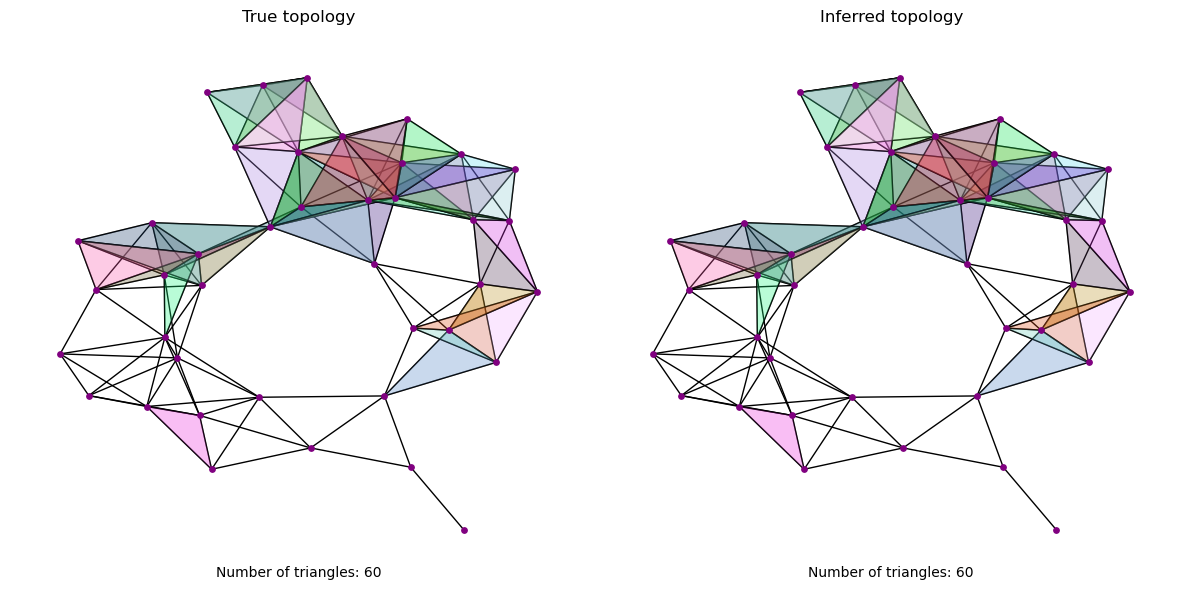

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import networkx as nx

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Repeat the plot for two times with different titles
for ax, title in zip(axs, ["True topology", "Inferred topology"]):
    A = G.get_adjacency()
    tmp_G = nx.from_numpy_array(A)
    pos = nx.kamada_kawai_layout(tmp_G)
    nx.draw(tmp_G, pos, with_labels=False, node_color='purple', node_size=15, ax=ax)
    incidence_mat = B2_true if  ax == axs[0] else topoX.B2
    num_triangles=0
    # Draw triangles with their corresponding colors
    for triangle_index in range(topoX.B2.shape[1]):
        np.random.seed(triangle_index)
        color = np.random.rand(3)
        triangle_vertices=[]
        # Get the edges corresponding to the triangle
        triangle_edges = []
        for edge_index, edge in enumerate(tmp_G.edges):
            if edge_index<sub_size:
                if incidence_mat[edge_index, triangle_index] != 0:
                    pos1 = tuple(pos[edge[0]])
                    pos2 = tuple(pos[edge[1]])
                    if pos1 not in triangle_vertices:
                        triangle_vertices.append(pos1)
                    if pos2 not in triangle_vertices:
                        triangle_vertices.append(pos2)                
        if triangle_vertices!= []:
            num_triangles += 1
            triangle_patch = Polygon(triangle_vertices, closed=True, facecolor=color, edgecolor='black', alpha=0.3)
            ax.add_patch(triangle_patch)

    ax.set_title(title)
    ax.text(0.5, -0, "Number of triangles: {}".format(num_triangles), ha='center', transform=ax.transAxes)
plt.tight_layout()
plt.show()

### SDP 80 (meno di 80 in realtà)

In [17]:
import warnings
warnings.filterwarnings("ignore")

s = 8
c = c_true[s]  
epsilon = epsilon_true[s] 
k0 = K0_coll[4]

topoX = TspSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                c=c_true[s],
                epsilon=epsilon_true[s],
                K0=K0_coll[4],
                true_prob_T=prob_T,
                P=P,
                J=J,
                dictionary_type=dictionary_type,
                p_edges=0.162,
                seed=0,
                n=40,
                sub_size=100)

step_h=1
step_x=1

min_error_test, history, Lu_new, B2_new = topoX.learn_upper_laplacian(lambda_=lambda_, 
                                                              max_iter=max_iter,
                                                              patience=patience, 
                                                              tol=tol,
                                                              step_h=step_h,
                                                              step_x=step_x,
                                                              verbose=True)

Removing 1 triangle from topology... 
 ... New min test error: 0.007772506444238211 !
Removing 1 triangle from topology... 
 ... New min test error: 0.006792012113195896 !
Removing 1 triangle from topology... 
 ... New min test error: 0.005977625777028271 !
Removing 1 triangle from topology... 
 ... New min test error: 0.005509328679909786 !
Removing 1 triangle from topology... 
 ... New min test error: 0.005328091912711834 !
Removing 1 triangle from topology... 
 ... New min test error: 0.005115237439789292 !
Removing 1 triangle from topology... 
 ... New min test error: 0.004774705330031252 !
Removing 1 triangle from topology... 
 ... New min test error: 0.0046860801984446535 !
Removing 1 triangle from topology... 
 ... New min test error: 0.004452047182202025 !
Removing 1 triangle from topology... 
 ... New min test error: 0.004340414780293739 !
Removing 1 triangle from topology... 
 ... New min test error: 0.004165310015764846 !
Removing 1 triangle from topology... 
 ... New min te

In [19]:
np.all(topoX.B2 == B2_true)

True

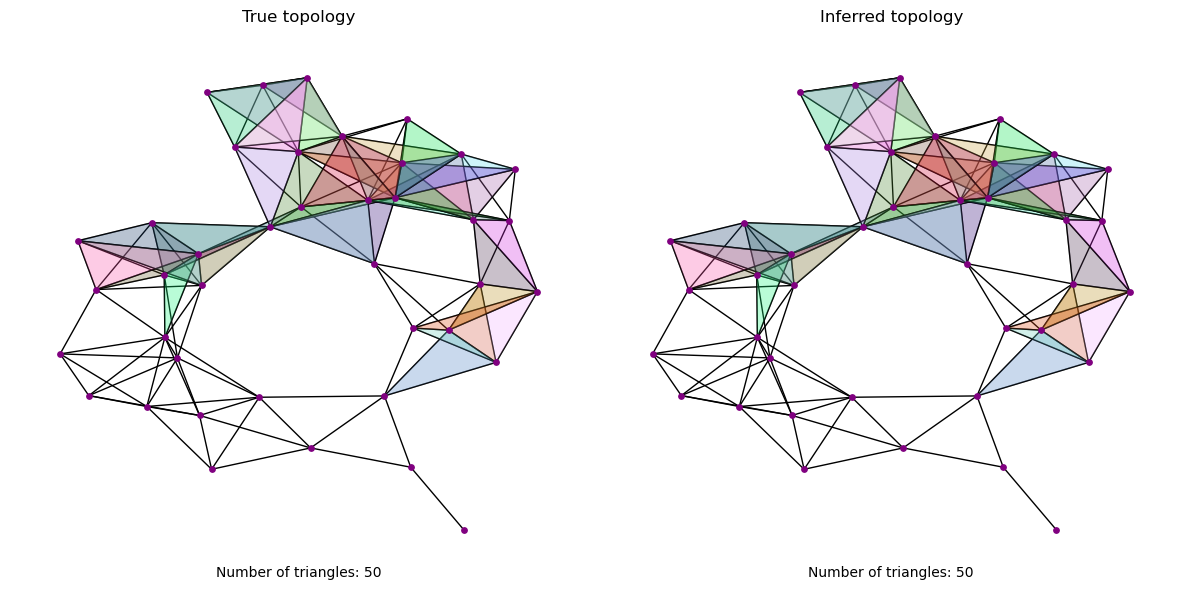

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import networkx as nx

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Repeat the plot for two times with different titles
for ax, title in zip(axs, ["True topology", "Inferred topology"]):
    A = G.get_adjacency()
    tmp_G = nx.from_numpy_array(A)
    pos = nx.kamada_kawai_layout(tmp_G)
    nx.draw(tmp_G, pos, with_labels=False, node_color='purple', node_size=15, ax=ax)
    incidence_mat = B2_true if ax == axs[0] else topoX.B2
    num_triangles=0
    # Draw triangles with their corresponding colors
    for triangle_index in range(topoX.B2.shape[1]):
        np.random.seed(triangle_index)
        color = np.random.rand(3)
        triangle_vertices=[]
        # Get the edges corresponding to the triangle
        triangle_edges = []
        for edge_index, edge in enumerate(tmp_G.edges):
            if edge_index<sub_size:
                if incidence_mat[edge_index, triangle_index] != 0:
                    pos1 = tuple(pos[edge[0]])
                    pos2 = tuple(pos[edge[1]])
                    if pos1 not in triangle_vertices:
                        triangle_vertices.append(pos1)
                    if pos2 not in triangle_vertices:
                        triangle_vertices.append(pos2)                
        if triangle_vertices!= []:
            num_triangles += 1
            triangle_patch = Polygon(triangle_vertices, closed=True, facecolor=color, edgecolor='black', alpha=0.3)
            ax.add_patch(triangle_patch)

    ax.set_title(title)
    ax.text(0.5, -0, "Number of triangles: {}".format(num_triangles), ha='center', transform=ax.transAxes)
plt.tight_layout()
plt.show()

### SDP 50

In [6]:
import warnings
warnings.filterwarnings("ignore")

s = 8
c = c_true[s]  
epsilon = epsilon_true[s] 
k0 = K0_coll[4]

topoX = TspSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                c=c_true[s],
                epsilon=epsilon_true[s],
                K0=K0_coll[4],
                true_prob_T=prob_T,
                P=P,
                J=J,
                dictionary_type=dictionary_type,
                p_edges=0.162,
                seed=0,
                n=40,
                sub_size=100)

step_h=1
step_x=1

min_error_test, history, Lu_new, B2_new = topoX.learn_upper_laplacian(lambda_=lambda_, 
                                                              max_iter=max_iter,
                                                              patience=patience, 
                                                              tol=tol,
                                                              step_h=step_h,
                                                              step_x=step_x,
                                                              verbose=True)

Removing 1 triangle from topology... 
 ... New min test error: 0.010986489203751471 !
Removing 1 triangle from topology... 
 ... New min test error: 0.010694739825059169 !
Removing 1 triangle from topology... 
 ... New min test error: 0.010267010308397176 !
Removing 1 triangle from topology... 
 ... New min test error: 0.010000005488604162 !
Removing 1 triangle from topology... 
 ... New min test error: 0.009533180938540005 !
Removing 1 triangle from topology... 
 ... New min test error: 0.009289708514536539 !
Removing 1 triangle from topology... 
 ... New min test error: 0.008820934932695437 !
Removing 1 triangle from topology... 
 ... New min test error: 0.008530338419356857 !
Removing 1 triangle from topology... 
 ... New min test error: 0.00802258471904555 !
Removing 1 triangle from topology... 
 ... New min test error: 0.007826566705659578 !
Removing 1 triangle from topology... 
 ... New min test error: 0.007406828017688391 !
Removing 1 triangle from topology... 
 ... New min test

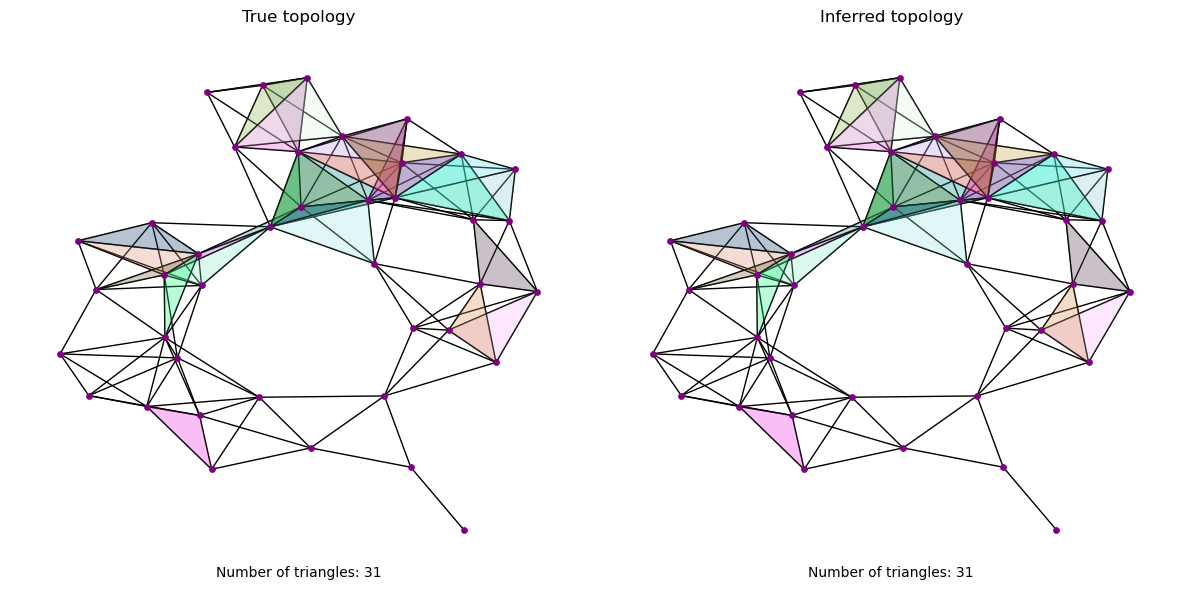

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import networkx as nx

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Repeat the plot for two times with different titles
for ax, title in zip(axs, ["True topology", "Inferred topology"]):
    A = G.get_adjacency()
    tmp_G = nx.from_numpy_array(A)
    pos = nx.kamada_kawai_layout(tmp_G)
    nx.draw(tmp_G, pos, with_labels=False, node_color='purple', node_size=15, ax=ax)
    incidence_mat = B2_true if ax == axs[0] else topoX.B2
    num_triangles=0
    # Draw triangles with their corresponding colors
    for triangle_index in range(topoX.B2.shape[1]):
        np.random.seed(triangle_index)
        color = np.random.rand(3)
        triangle_vertices=[]
        # Get the edges corresponding to the triangle
        triangle_edges = []
        for edge_index, edge in enumerate(tmp_G.edges):
            if edge_index<sub_size:
                if incidence_mat[edge_index, triangle_index] != 0:
                    pos1 = tuple(pos[edge[0]])
                    pos2 = tuple(pos[edge[1]])
                    if pos1 not in triangle_vertices:
                        triangle_vertices.append(pos1)
                    if pos2 not in triangle_vertices:
                        triangle_vertices.append(pos2)                
        if triangle_vertices!= []:
            num_triangles += 1
            triangle_patch = Polygon(triangle_vertices, closed=True, facecolor=color, edgecolor='black', alpha=0.3)
            ax.add_patch(triangle_patch)

    ax.set_title(title)
    ax.text(0.5, -0, "Number of triangles: {}".format(num_triangles), ha='center', transform=ax.transAxes)
plt.tight_layout()
plt.show()

In [8]:
np.all(topoX.B2 == B2_true)

True

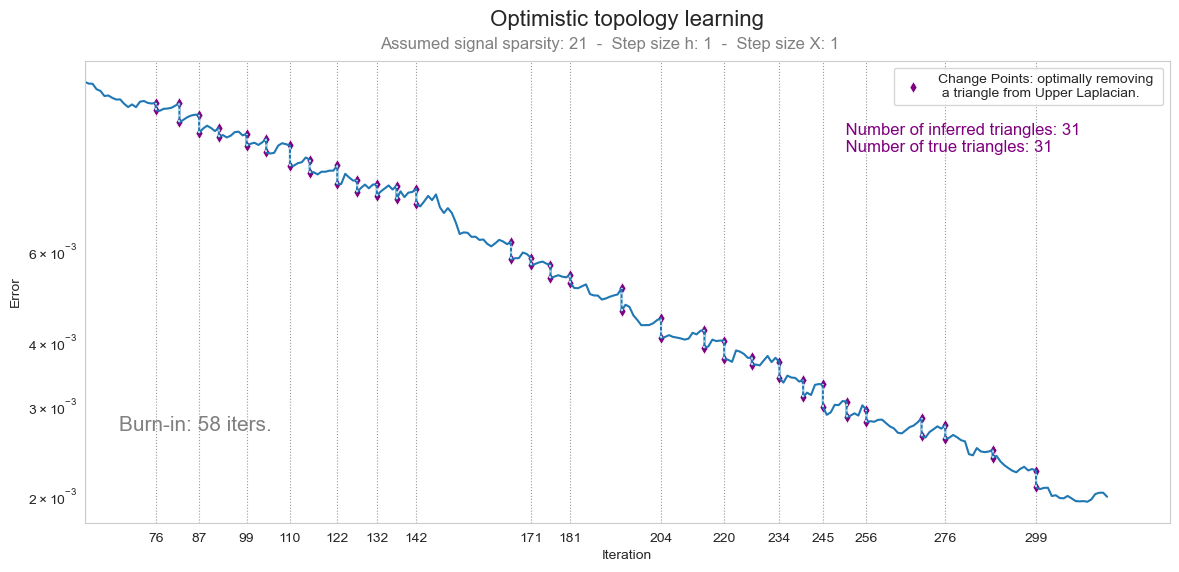

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

T = int(np.ceil(nu*(1-prob_T)))
burn_in = 0.75
sparse_plot = True
a=0.2
b=0.2
c=0.7
d=0.75

start_iter = 0
end_iter = 0
change_points = []
change_points_y1 = []
change_points_y2 = []
burn_in_iter = 0
his=[]
xx = []
for i,h in enumerate(history):
    if i == 0:
        burn_in_iter=int(np.ceil(burn_in*len(h)))
    his+=h
    end_iter += len(h)-1
    tmp = range(start_iter, end_iter+1)
    xx += tmp
    start_iter = end_iter
    change_points.append(end_iter)
    change_points_y1.append(h[-1])
    change_points_y2.append(h[0])

plt_data = pd.DataFrame({'y':his[burn_in_iter:], 
                   'x':xx[burn_in_iter:]})

change_points = np.array(change_points[:-1])
change_points_y1 = np.array(change_points_y1[:-1])
change_points_y2 = np.array(change_points_y2[1:])
# change_points_y = plt_data[plt_data['x'].isin(change_points)].y.to_numpy()[np.arange(0, len(change_points), 1)]

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

my_plt = sns.lineplot(x=plt_data['x'],y=plt_data['y'], estimator=None, sort=False)

# Change-points
sns.scatterplot(x=np.hstack([change_points, change_points]),
                 y=np.hstack([change_points_y1, change_points_y2]),
                 label='Change Points: optimally removing \n a triangle from Upper Laplacian.',
                 color='purple', marker='d')

plt.vlines(x=change_points, color='lightblue', linestyle='dotted', 
           ymax=change_points_y1, ymin=change_points_y2)

# Burn-in area
plt.axvspan(0, burn_in_iter, color='grey', alpha=0.2, hatch='//')
x0, xmax = plt.xlim()
x0 = burn_in_iter
y0, ymax = plt.ylim()
my_plt.set_title(f'Optimistic topology learning',fontsize=16, pad=25)
plt.suptitle(f'Assumed signal sparsity: {k0}  -  Step size h: {step_h}  -  Step size X: {step_x}', fontsize=12, color='gray', x=0.5, y=0.92)
plt.text(y=ymax*a, x=xmax*b, s=f'Burn-in: {burn_in_iter} iters.', fontsize=15, color='gray')
plt.text(s=f' Number of inferred triangles: {nu - change_points.shape[0]} \n Number of true triangles: {nu-T}',
         y=ymax*c, x=xmax*d, fontsize=12, color='purple')
my_plt.set_xlabel('Iteration')
my_plt.set_ylabel('Error')
if sparse_plot:
    tmp_vector = np.ones(len(change_points))
    tmp_vector[1::2] = 0
    plt.xticks(change_points*tmp_vector)
else:
    plt.xticks(change_points)
plt.xlim(left=burn_in_iter)
plt.yscale('log')
plt.yticks([])
plt.show() 

### SDP 50 pessimistic

In [120]:
topoX = TspSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                **topo_params)

In [121]:
import warnings
warnings.filterwarnings("ignore")

min_error_test, history, Lu_new, B2_new = topoX.learn_upper_laplacian(lambda_=lambda_, 
                                        max_iter=max_iter,
                                        patience=patience, 
                                        tol=tol,
                                        verbose=True,
                                        mode="pessimistic",
                                        warmup=5)

Adding 1 triangle to topology... 
 ... New min test error: 0.02000427108202324 !
Adding 1 triangle to topology... 
 ... New min test error: 0.02000427108202324 !
Adding 1 triangle to topology... 
 ... New min test error: 0.018766233658532763 !
Adding 1 triangle to topology... 
 ... New min test error: 0.018071549800775206 !
Adding 1 triangle to topology... 
 ... New min test error: 0.017419712355681412 !
Adding 1 triangle to topology... 
 ... New min test error: 0.017241010219474922 !
Adding 1 triangle to topology... 
 ... New min test error: 0.01654687298353152 !
Adding 1 triangle to topology... 
 ... New min test error: 0.01603520970593201 !
Adding 1 triangle to topology... 
 ... New min test error: 0.01572965631189149 !
Adding 1 triangle to topology... 
 ... New min test error: 0.015496551492745212 !
Adding 1 triangle to topology... 
 ... New min test error: 0.015083683465040909 !
Adding 1 triangle to topology... 
 ... New min test error: 0.014632320999317772 !
Adding 1 triangle to 

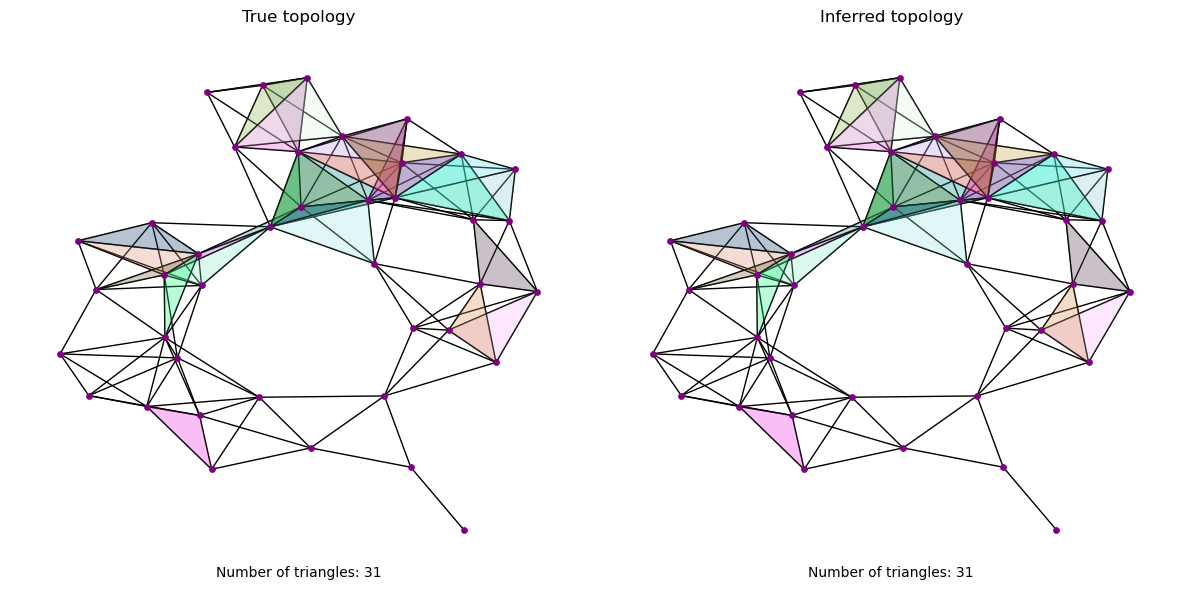

In [122]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import networkx as nx

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Repeat the plot for two times with different titles
for ax, title in zip(axs, ["True topology", "Inferred topology"]):
    A = G.get_adjacency()
    tmp_G = nx.from_numpy_array(A)
    pos = nx.kamada_kawai_layout(tmp_G)
    nx.draw(tmp_G, pos, with_labels=False, node_color='purple', node_size=15, ax=ax)
    incidence_mat = B2_true if ax == axs[0] else topoX.B2
    num_triangles=0
    # Draw triangles with their corresponding colors
    for triangle_index in range(topoX.B2.shape[1]):
        np.random.seed(triangle_index)
        color = np.random.rand(3)
        triangle_vertices=[]
        # Get the edges corresponding to the triangle
        triangle_edges = []
        for edge_index, edge in enumerate(tmp_G.edges):
            if edge_index<sub_size:
                if incidence_mat[edge_index, triangle_index] != 0:
                    pos1 = tuple(pos[edge[0]])
                    pos2 = tuple(pos[edge[1]])
                    if pos1 not in triangle_vertices:
                        triangle_vertices.append(pos1)
                    if pos2 not in triangle_vertices:
                        triangle_vertices.append(pos2)                
        if triangle_vertices!= []:
            num_triangles += 1
            triangle_patch = Polygon(triangle_vertices, closed=True, facecolor=color, edgecolor='black', alpha=0.3)
            ax.add_patch(triangle_patch)

    ax.set_title(title)
    ax.text(0.5, -0, "Number of triangles: {}".format(num_triangles), ha='center', transform=ax.transAxes)
plt.tight_layout()
plt.show()

In [126]:
step_h=1.
step_x=1.

In [141]:
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

def plot_changepoints_curve(history, 
                            k0, 
                            nu, 
                            T, 
                            mode,
                            burn_in: float = 0, 
                            a=0.1, 
                            b=0.1, 
                            c=0.7, 
                            d=0.7,
                            sparse_plot=False,
                            include_burn_in=False,
                            step_h=1.,
                            step_x=1.):

    start_iter = 0
    end_iter = 0
    change_points = []
    change_points_y1 = []
    change_points_y2 = []
    burn_in_iter = 0
    his=[]
    xx = []
    for i,h in enumerate(history):
        if i == 0:
            burn_in_iter=int(np.ceil(burn_in*len(h)))
        his+=h
        end_iter += len(h)-1
        tmp = range(start_iter, end_iter+1)
        xx += tmp
        start_iter = end_iter
        change_points.append(end_iter)
        change_points_y1.append(h[-1])
        change_points_y2.append(h[0])

    plt_data = pd.DataFrame({'y':his[burn_in_iter:], 
                    'x':xx[burn_in_iter:]})

    change_points = np.array(change_points[:-1])
    change_points_y1 = np.array(change_points_y1[:-1])
    change_points_y2 = np.array(change_points_y2[1:])
    # change_points_y = plt_data[plt_data['x'].isin(change_points)].y.to_numpy()[np.arange(0, len(change_points), 1)]

    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

    my_plt = sns.lineplot(x=plt_data['x'],y=plt_data['y'], estimator=None, sort=False)

    labels = ("removing", "Optimistic") if mode=="optimistic" else ("adding", "Pessimistic")
    # Change-points
    sns.scatterplot(x=np.hstack([change_points, change_points]),
                    y=np.hstack([change_points_y1, change_points_y2]),
                    label=f'Change Points: optimally {labels[0]} \n a triangle from Upper Laplacian.',
                    color='purple', marker='d')

    plt.vlines(x=change_points, color='lightblue', linestyle='dotted', 
            ymax=change_points_y1, ymin=change_points_y2)

    # Burn-in area
    plt.axvspan(0, burn_in_iter, color='grey', alpha=0.2, hatch='//')
    if include_burn_in:
        x0, xmax = plt.xlim()
    else:
        x0, xmax = plt.xlim()
        x0 = burn_in_iter
    y0, ymax = plt.ylim()
    my_plt.set_title(f'{labels[1]} topology learning',fontsize=16, pad=25)
    plt.suptitle(f'Assumed signal sparsity: {k0}  -  Step size h: {step_h}  -  Step size X: {step_x}', fontsize=12, color='gray', x=0.5, y=0.92)
    plt.text(y=ymax*a, x=xmax*b, s=f'Burn-in: {burn_in_iter} iters.', fontsize=15, color='gray')
    plt.text(s=f' Number of inferred triangles: {nu - change_points.shape[0]} \n Number of true triangles: {nu-T}',
            y=ymax*c, x=xmax*d, fontsize=12, color='purple')
    my_plt.set_xlabel('Iteration')
    my_plt.set_ylabel('Error')
    if sparse_plot:
        tmp_vector = np.ones(len(change_points))
        tmp_vector[1::2] = 0
        plt.xticks(change_points*tmp_vector)
    else:
        plt.xticks(change_points)
    plt.xlim(left=x0)
    plt.yscale('log')
    plt.yticks([])
    plt.show() 

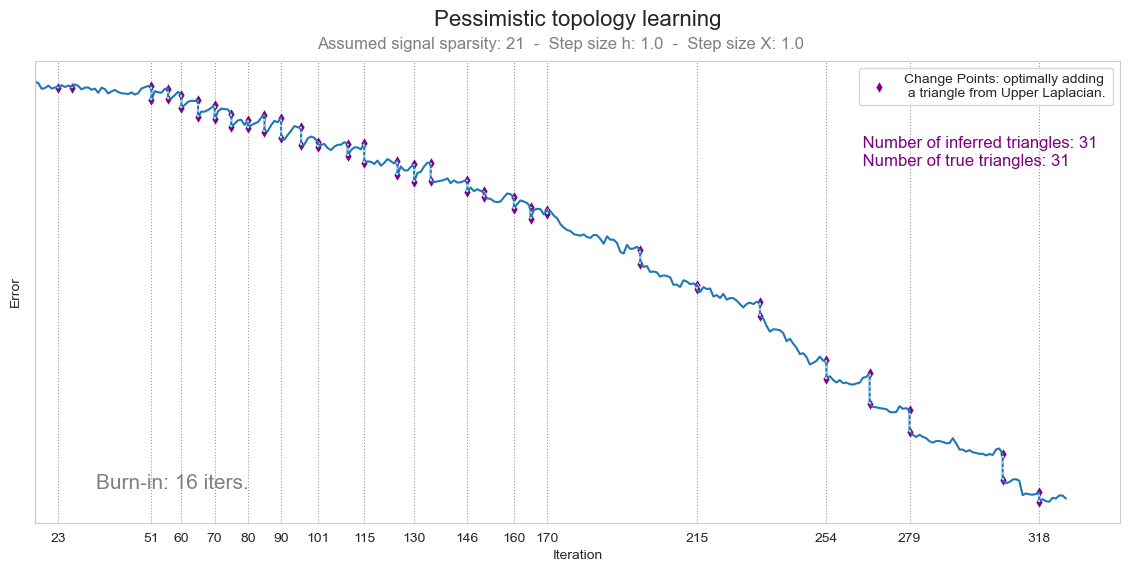

In [147]:
plot_changepoints_curve(history=history, 
                            k0=topoX.K0, 
                            nu=topoX.nu, 
                            T=T, 
                            mode="pessimistic",
                            burn_in= 0.65, 
                            a=0.1, 
                            b=0.1, 
                            c=0.6, 
                            d=0.77,
                            sparse_plot=True,
                            include_burn_in=False)

In [111]:
topoX.h_opt

[array([[1.0460155 ],
        [1.27923614],
        [0.2495637 ]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([[-0.20406971,  0.01826612],
        [ 0.10020791, -0.01006605],
        [ 0.0854424 ,  0.0056173 ]])]

In [110]:
sigmas

,idx,sigma,Luj,D,X,NMSE
0,1,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[2.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[[0.8570695270593309, -0.09447298871726076, -0...","[[0.0, 0.0, 0.0, 1.8868564863553268, 0.0, 0.0,...",0.020004
1,2,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[2.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0...","[[0.8570695270593309, -0.09447298871726076, -0...","[[0.0, 0.0, 0.0, 1.8868564863553268, 0.0, 0.0,...",0.020004
2,3,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[2.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0...","[[0.8570695270593309, -0.09447298871726076, -0...","[[0.0, 0.0, 0.0, 1.8868564863553268, 0.0, 0.0,...",0.020004
3,4,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.8570695270593309, -0.09447298871726076, -0...","[[0.0, 0.0, 0.0, 1.8868564863553268, 0.0, 0.0,...",0.020004
4,5,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.8570695270593309, -0.09447298871726076, -0...","[[0.0, 0.0, 0.0, 1.8868564863553268, 0.0, 0.0,...",0.020004
...,...,...,...,...,...,...
56,57,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.8570695270593309, -0.09447298871726076, -0...","[[0.0, 0.0, 0.0, 1.8868564863553268, 0.0, 0.0,...",0.020004
57,58,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.8570695270593309, -0.09447298871726076, -0...","[[0.0, 0.0, 0.0, 1.8868564863553268, 0.0, 0.0,...",0.020004
58,59,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.8570695270593309, -0.09447298871726076, -0...","[[0.0, 0.0, 0.0, 1.8868564863553268, 0.0, 0.0,...",0.020004
59,60,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.8570695270593309, -0.09447298871726076, -0...","[[0.0, 0.0, 0.0, 1.8868564863553268, 0.0, 0.0,...",0.020004


In [91]:
sigmas.sigma[0] = sigmas2.sigma[0]

In [92]:
tmp = topoX.B2@sigmas.sigma[0]@topoX.B2.T
D_tmp = generate_dictionary(topoX.h_opt, topoX.P, np.array([la.matrix_power(tmp, i) for i in range(1, J + 1)]), topoX.Ldj)

In [93]:
tmp2 = topoX.B2@sigmas.sigma[2]@topoX.B2.T
D_tmp2 = generate_dictionary(topoX.h_opt, topoX.P, np.array([la.matrix_power(tmp2, i) for i in range(1, J + 1)]), topoX.Ldj)

In [97]:
topoX.h_opt

[array([[1.0460155 ],
        [1.27923614],
        [0.2495637 ]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([[-0.20406971,  0.01826612],
        [ 0.10020791, -0.01006605],
        [ 0.0854424 ,  0.0056173 ]])]

In [96]:
np.all(tmp==sigmas2.D[0])

False

In [50]:
np.all(sigmas.D[1] == sigmas.D[2])

True

In [45]:
sigmas.apply(lambda x: generate_dictionary(topoX.h_opt, topoX.P, x.Luj, topoX.Ldj), axis=1)

0     [[0.8570695274310149, -0.09447298809310997, -0...
1     [[0.8570695274310149, -0.09447298809310997, -0...
2     [[0.8570695274310149, -0.09447298809310997, -0...
3     [[0.8570695274310149, -0.09447298809310997, -0...
4     [[0.8570695274310149, -0.09447298809310997, -0...
                            ...                        
57    [[0.8570695274310149, -0.09447298809310997, -0...
58    [[0.8570695274310149, -0.09447298809310997, -0...
59    [[0.8570695274310149, -0.09447298809310997, -0...
60    [[0.8570695274310149, -0.09447298809310997, -0...
61    [[0.8570695274310149, -0.09447298809310997, -0...
Length: 62, dtype: object

In [38]:
topoX2 = TspSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                **topo_params)

In [39]:
import warnings
warnings.filterwarnings("ignore")

sigmas2 = topoX2.learn_upper_laplacian(lambda_=lambda_, 
                                        max_iter=max_iter,
                                        patience=patience, 
                                        tol=tol,
                                        verbose=True)

In [41]:
sigmas2

,idx,sigma,Luj,D,X,NMSE
0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[3.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, ...","[[0.5898757792858128, 0.08539849471583148, -0....","[[0.0, 0.0, 0.0, 0.0, -1.420114751792708, 0.0,...",0.011464
1,1,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[3.0, -1.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, ...","[[0.5898757792858128, -0.12651188954111903, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.012298
2,2,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[3.0, -1.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, ...","[[0.5898757792858128, -0.12651188954111903, -0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.064533616956...",0.011193
3,3,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[3.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.5898757792858128, -0.12651188954111903, -0...","[[0.0, 0.0, 0.0, 1.825931865747488, 0.0, 0.0, ...",0.012271
4,4,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[4.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0,...","[[0.8017861635427634, -0.12651188954111903, -0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.677170975876...",0.011300
...,...,...,...,...,...,...
57,57,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[4.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0,...","[[0.8017861635427634, -0.12651188954111903, -0...","[[0.0, 0.0, 0.0, 1.9113837264400257, 0.0, 0.0,...",0.012007
58,58,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[4.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0,...","[[0.8017861635427634, -0.12651188954111903, -0...","[[0.0, 0.0, 0.0, 1.8895238957355678, 0.0, 0.0,...",0.011543
59,59,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[4.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0,...","[[0.8017861635427634, -0.12651188954111903, -0...","[[0.0, 0.0, 0.0, 1.8905980990312987, 0.0, 0.0,...",0.012164
60,60,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[4.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0,...","[[0.8017861635427634, -0.12651188954111903, -0...","[[0.0, 0.0, 0.0, 1.889412526347607, 0.0, 0.0, ...",0.011657


In [39]:
np.all(topoX2.Lu == Lu)

True

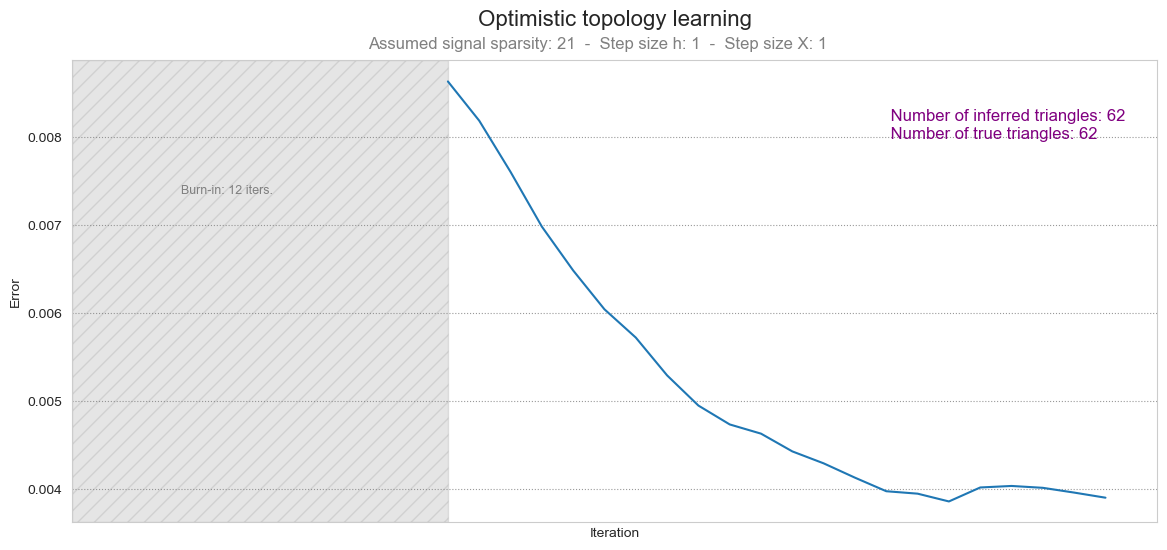

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

T = int(np.ceil(nu*(1-prob_T)))
burn_in = 0.35
start_iter = 0
end_iter = 0
change_points = []
change_points_y1 = []
change_points_y2 = []
burn_in_iter = 0
his=[]
xx = []
for i,h in enumerate(history):
    if i == 0:
        burn_in_iter=int(np.ceil(burn_in*len(h)))
    his+=h
    end_iter += len(h)-1
    tmp = range(start_iter, end_iter+1)
    xx += tmp
    start_iter = end_iter
    change_points.append(end_iter)
    change_points_y1.append(h[-1])
    change_points_y2.append(h[0])

plt_data = pd.DataFrame({'y':his[burn_in_iter:], 
                   'x':xx[burn_in_iter:]})

change_points = np.array(change_points[:-1])
change_points_y1 = np.array(change_points_y1[:-1])
change_points_y2 = np.array(change_points_y2[1:])
# change_points_y = plt_data[plt_data['x'].isin(change_points)].y.to_numpy()[np.arange(0, len(change_points), 1)]

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

my_plt = sns.lineplot(x=plt_data['x'],y=plt_data['y'], estimator=None, sort=False)

# Change-points
sns.scatterplot(x=np.hstack([change_points, change_points]),
                 y=np.hstack([change_points_y1, change_points_y2]),
                 label='Change Points: optimally removing \n a triangle from Upper Laplacian.',
                 color='purple', marker='d')

plt.vlines(x=change_points, color='lightblue', linestyle='dotted', 
           ymax=change_points_y1, ymin=change_points_y2)

# Burn-in area
plt.axvspan(0, burn_in_iter, color='grey', alpha=0.2, hatch='//')
x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
my_plt.set_title(f'Optimistic topology learning',fontsize=16, pad=25)
plt.suptitle(f'Assumed signal sparsity: {k0}  -  Step size h: {step_h}  -  Step size X: {step_x}', fontsize=12, color='gray', x=0.5, y=0.92)
plt.text(y=ymax*0.83, x=xmax*0.1, s=f'Burn-in: {burn_in_iter} iters.', fontsize=9, color='gray')
plt.text(s=f' Number of inferred triangles: {nu - change_points.shape[0]} \n Number of true triangles: {nu-T}',
         y=ymax*0.9, x=xmax*0.75, fontsize=12, color='purple')
my_plt.set_xlabel('Iteration')
my_plt.set_ylabel('Error')
plt.xticks(change_points)
# plt.yticks([])
plt.xlim(left=0)
#plt.yscale('log')
plt.show() 

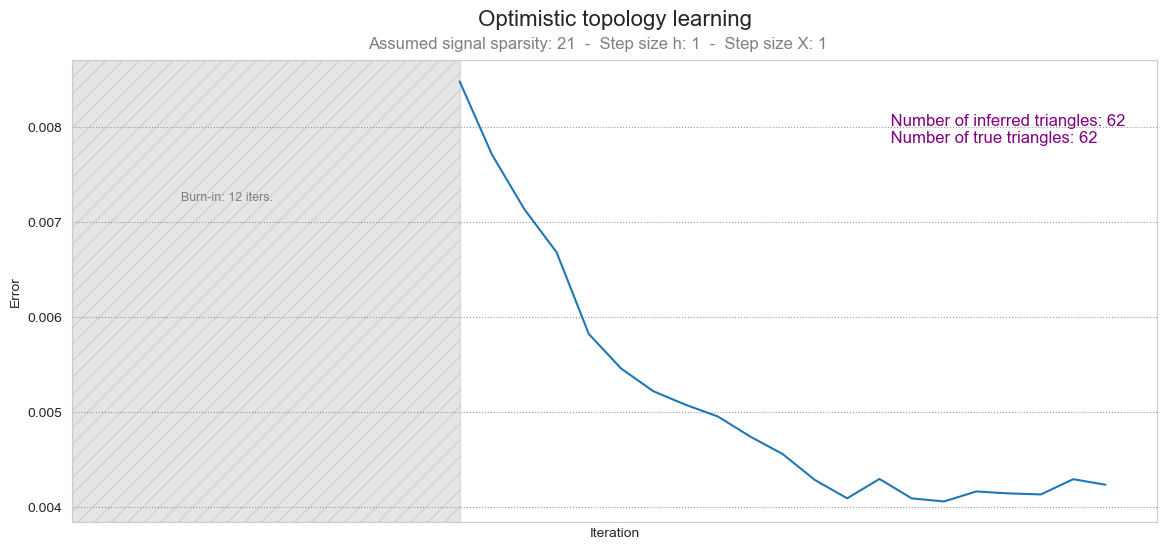

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

T = int(np.ceil(nu*(1-prob_T)))
burn_in = 0.35
start_iter = 0
end_iter = 0
change_points = []
change_points_y1 = []
change_points_y2 = []
burn_in_iter = 0
his=[]
xx = []
for i,h in enumerate(history):
    if i == 0:
        burn_in_iter=int(np.ceil(burn_in*len(h)))
    his+=h
    end_iter += len(h)-1
    tmp = range(start_iter, end_iter+1)
    xx += tmp
    start_iter = end_iter
    change_points.append(end_iter)
    change_points_y1.append(h[-1])
    change_points_y2.append(h[0])

plt_data = pd.DataFrame({'y':his[burn_in_iter:], 
                   'x':xx[burn_in_iter:]})

change_points = np.array(change_points[:-1])
change_points_y1 = np.array(change_points_y1[:-1])
change_points_y2 = np.array(change_points_y2[1:])
# change_points_y = plt_data[plt_data['x'].isin(change_points)].y.to_numpy()[np.arange(0, len(change_points), 1)]

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

my_plt = sns.lineplot(x=plt_data['x'],y=plt_data['y'], estimator=None, sort=False)

# Change-points
sns.scatterplot(x=np.hstack([change_points, change_points]),
                 y=np.hstack([change_points_y1, change_points_y2]),
                 label='Change Points: optimally removing \n a triangle from Upper Laplacian.',
                 color='purple', marker='d')

plt.vlines(x=change_points, color='lightblue', linestyle='dotted', 
           ymax=change_points_y1, ymin=change_points_y2)

# Burn-in area
plt.axvspan(0, burn_in_iter, color='grey', alpha=0.2, hatch='//')
x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
my_plt.set_title(f'Optimistic topology learning',fontsize=16, pad=25)
plt.suptitle(f'Assumed signal sparsity: {k0}  -  Step size h: {step_h}  -  Step size X: {step_x}', fontsize=12, color='gray', x=0.5, y=0.92)
plt.text(y=ymax*0.83, x=xmax*0.1, s=f'Burn-in: {burn_in_iter} iters.', fontsize=9, color='gray')
plt.text(s=f' Number of inferred triangles: {nu - change_points.shape[0]} \n Number of true triangles: {nu-T}',
         y=ymax*0.9, x=xmax*0.75, fontsize=12, color='purple')
my_plt.set_xlabel('Iteration')
my_plt.set_ylabel('Error')
plt.xticks(change_points)
# plt.yticks([])
plt.xlim(left=0)
#plt.yscale('log')
plt.show() 

In [16]:
min_error_fou_train = np.zeros((n_sim, len(K0_coll)))
min_error_fou_test = np.zeros((n_sim, len(K0_coll)))
min_error_sep_train = np.zeros((n_sim, len(K0_coll)))
min_error_sep_test = np.zeros((n_sim, len(K0_coll)))
min_error_edge_train = np.zeros((n_sim, len(K0_coll)))
min_error_edge_test = np.zeros((n_sim, len(K0_coll)))
min_error_joint_train = np.zeros((n_sim, len(K0_coll)))
min_error_joint_test = np.zeros((n_sim, len(K0_coll)))

dict_errors = {
    "fou": (min_error_fou_train,min_error_fou_test),
    "edge": (min_error_edge_train,min_error_edge_test),
    "joint": (min_error_joint_train,min_error_joint_test),
    "sep": (min_error_sep_train,min_error_sep_test)
    }


dict_types = {
    "fou": ("Fourier","fourier"),
    "edge": ("Edge Laplacian", "edge_laplacian"),
    "joint": ("Hodge Laplacian","joint"),
    "sep": ("Separated Hodge Laplacian","separated")
    }

for sim in range(n_sim):
    c = c_true[sim]  
    epsilon = epsilon_true[sim] 
    for k0_index, k0 in tqdm(enumerate(K0_coll)):

        for d in dict_types.items():
            
            model = TspSolver(X_train=X_train[:, :, sim], 
                                X_test=X_test[:, :, sim], 
                                Y_train=Y_train[:, :, sim], 
                                Y_test=Y_test[:, :, sim],
                                c=c_true[sim],
                                epsilon=epsilon_true[sim],
                                K0=K0_coll[k0_index],
                                true_prob_T=prob_T,
                                P=P,
                                J=J,
                                dictionary_type=dictionary_type,
                                p_edges=0.162,
                                seed=0,
                                n=40,
                                sub_size=100)
            try:
                model.init_dict()
            except:
                print("Initialization Failed!")
            try:
                dict_errors[d[0]][0][sim,k0_index], dict_errors[d[0]][1][sim,k0_index], _ = model.topological_dictionary_learn(lambda_=lambda_, 
                                                                                                                                max_iter=max_iter,
                                                                                                                                patience=patience, 
                                                                                                                                tol=tol,
                                                                                                                                step_h=step_h,
                                                                                                                                step_x=step_x)
                if verbose:
                    print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing {d[1][0]}... Done! Test Error: {dict_errors[d[0]][1][sim,k0_index]}")
            except:
                print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing {d[1][0]}... Diverged!')
                try:
                    dict_errors[d[0]][0][sim,k0_index], dict_errors[d[0]][1][sim,k0_index] = (dict_errors[d[0]][0][sim-1,k0_index]
                                                                                            , dict_errors[d[0]][1][sim-1,k0_index])
                except:
                    dict_errors[d[0]][0][sim,k0_index], dict_errors[d[0]][1][sim,k0_index] = (dict_errors[d[0]][0][sim+1,k0_index]
                                                                                            , dict_errors[d[0]][1][sim+1,k0_index])

0.006313767188528604

In [12]:
xmax

60.9